In [1]:
"""
NDVI (Normalized Difference Vegetation Index)
This most known and used vegetation index is a simple,
but effective VI for quantifying green vegetation.
It normalizes green leaf scattering in the Near Infra-red wavelength and chlorophyll absorption in the red wavelength.
Values description: The value range of an NDVI is -1 to 1. 
Negative values of NDVI (values approaching -1) correspond to water. 
Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. 
Low, positive values represent shrub and grassland (approximately 0.2 to 0.4), 
while high values indicate temperate and tropical rainforests (values approaching 1).
"""


"""
NDWI (Normalized Difference Water Index)
The NDWI index is most appropriate for water body mapping. 
The water body has strong absorbability and low radiation in the range from visible to infrared wavelengths. 
The index uses the green and Near Infra-red bands of remote sensing images based on this phenomenon. 
The NDWI can enhance the water information effectively in most cases. 
It is sensitive to built-up land and often results in over-estimated water bodies. 

Values description: Values of water bodies are larger than 0.5. 
Vegetation has much smaller values, which results in distinguishing vegetation from water bodies easier. 
Built-up features have positive values between zero and 0.2.
"""

# Look at other indices also, at https://www.sentinel-hub.com/develop/documentation/eo_products/Sentinel2EOproducts

#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask
import fiona
import pandas as pd
from helpers import return_indices
%matplotlib inline


In [5]:
# For testing also we need all of this
blue = rasterio.open('./All_Indices/S2_Mandya_B2.tif')
green = rasterio.open('./All_Indices/S2_Mandya_B3.tif')
red = rasterio.open('./All_Indices/S2_Mandya_B4.tif')
vre5 = rasterio.open('./All_Indices/S2_Mandya_B05.tif')
vre6 = rasterio.open('./All_Indices/S2_Mandya_B06.tif')
vre7 = rasterio.open('./All_Indices/S2_Mandya_B07.tif')
nir = rasterio.open('./All_Indices/S2_Mandya_B8.tif')
vre8a = rasterio.open('./All_Indices/S2_Mandya_B08A.tif')
swir11 = rasterio.open('./All_Indices/S2_Mandya_B11.tif')
swir12 = rasterio.open('./All_Indices/S2_Mandya_B12.tif')

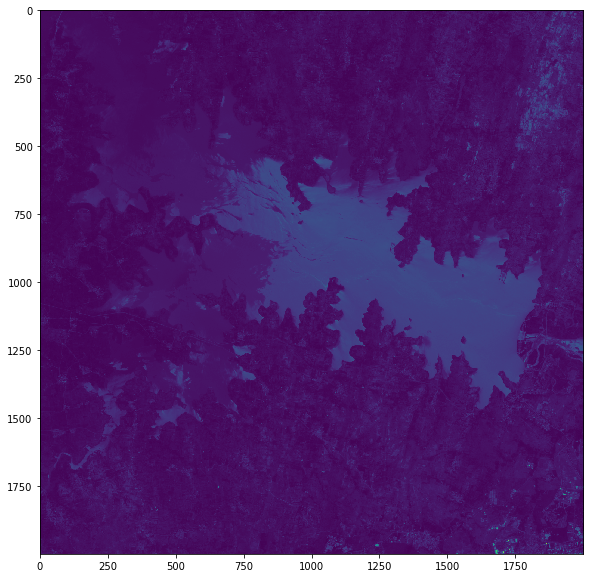

In [6]:
fig = plt.figure(figsize=(10,10))
img1 = blue.read(1)
plot.show(img1[6000:8000, 1500:3500])

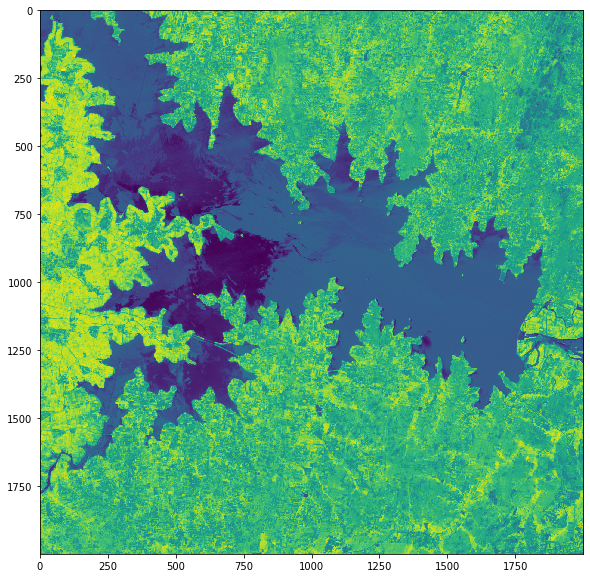

In [8]:
# ndvi from qgis
ndvi_8_4 = rasterio.open('./All_Indices/ndvi_8_4.tif')
fig = plt.figure(figsize=(10,10))
img = ndvi_8_4.read(1)
plot.show(img[6000:8000, 1500:3500])

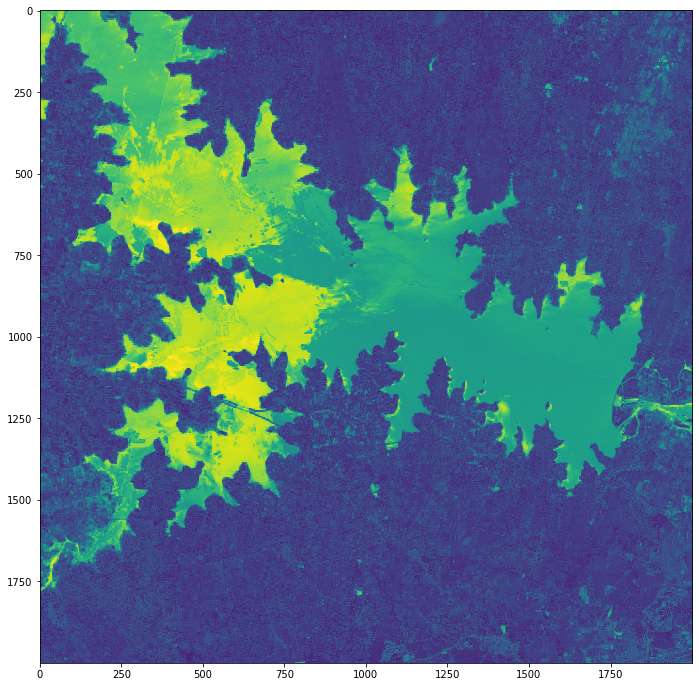

In [10]:
mndwi_4_11 = rasterio.open('./All_Indices/mndwi_4_11.tif')
fig = plt.figure(figsize=(18,12))
img = mndwi_4_11.read(1)
plot.show(img[6000:8000, 1500:3500])

In [11]:
# Final numpy array must be structured as follows
# Shape of array - [14, 10131, 12032]
# n - number of features / indices considered

# Features : [B02, B03, B04, B05, B06, B07, B8, B08A, B11, B12, ndvi, mndwi, ndbi]

In [16]:
feature_list = ["S2_Mandya_B2", "S2_Mandya_B3", "S2_Mandya_B4", "S2_Mandya_B05", "S2_Mandya_B06", 
                "S2_Mandya_B07", "S2_Mandya_B8", "S2_Mandya_B08A", "S2_Mandya_B11", "S2_Mandya_B12", 
                "ndvi_8_4", "mndwi_4_11", "ndbi_11_8"]
# "ndvi_8_4", "mndwi_4_11", "ndbi_11_8" will be added later in code
FOLDER = "./All_Indices/"

In [17]:
final_feature_array = []

In [18]:
# Indices are computed in helpers
for feature in feature_list[0:-3]:
    file = FOLDER + feature + ".tif"
    with rasterio.open(file) as src:
        image = src.read(1)
        final_feature_array.append(image[6000:8000, 1500:3500])

In [19]:
ndvi, mndwi, ndbi = return_indices(final_feature_array)

In [20]:
final_feature_array.append(ndvi)
final_feature_array.append(mndwi)
final_feature_array.append(ndbi)

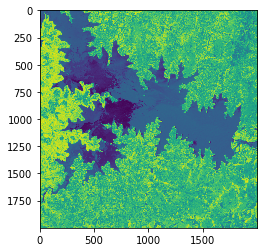

In [21]:
# ndvi from rasterio
plot.show(final_feature_array[-3])

In [22]:
final_features = np.array(final_feature_array)

In [23]:
# Normalize features to same scale before training

In [24]:
final_features.shape

(13, 2000, 2000)

In [30]:
with fiona.open("./shpfiles/shpfile.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [31]:
with rasterio.open("./All_Indices/mndwi_4_11.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=False)
    out_meta = src.meta
    
out_meta.update(
    {"driver": "GTiff",
     "height": out_image.shape[1],
     "width": out_image.shape[2],
     "transform": out_transform})

In [32]:
with rasterio.open("./target_tifs/masked_water_mndwi.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [33]:
out_image.shape

(4, 10131, 12032)

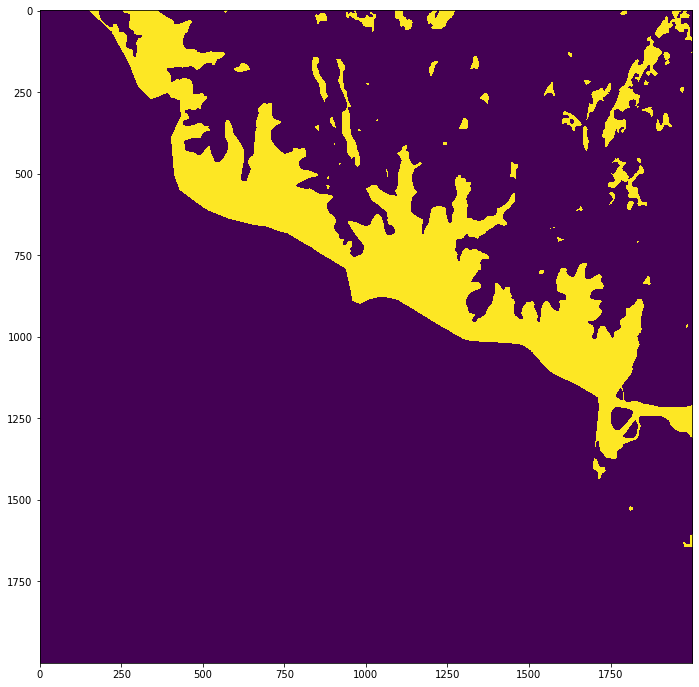

In [34]:
with rasterio.open('./target_tifs/masked_water_mndwi.tif') as water_mask:
    mandya_water_mask = water_mask.read(4)
fig = plt.figure(figsize=(18, 12))
plot.show(mandya_water_mask[6000:8000, 1500:3500])

In [37]:
with fiona.open("./shpfiles/correct_distshapefile.shp", "r") as shapefile:
    shapes_dist = [feature["geometry"] for feature in shapefile]

In [38]:
with rasterio.open("./All_Indices/mndwi_4_11.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes_dist, crop=False)
    out_meta = src.meta
    
out_meta.update(
    {"driver": "GTiff", 
     "height": out_image.shape[1], 
     "width": out_image.shape[2],
     "transform": out_transform})

In [39]:
out_image[0].shape

(10131, 12032)

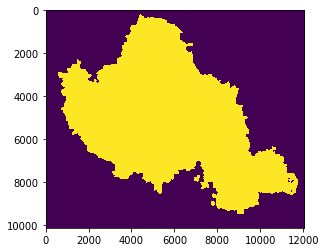

In [40]:
plot.show(out_image[3])

In [41]:
with rasterio.open("./target_tifs/masked_dist.tif", "w", **out_meta) as dest:
    dest.write(out_image)

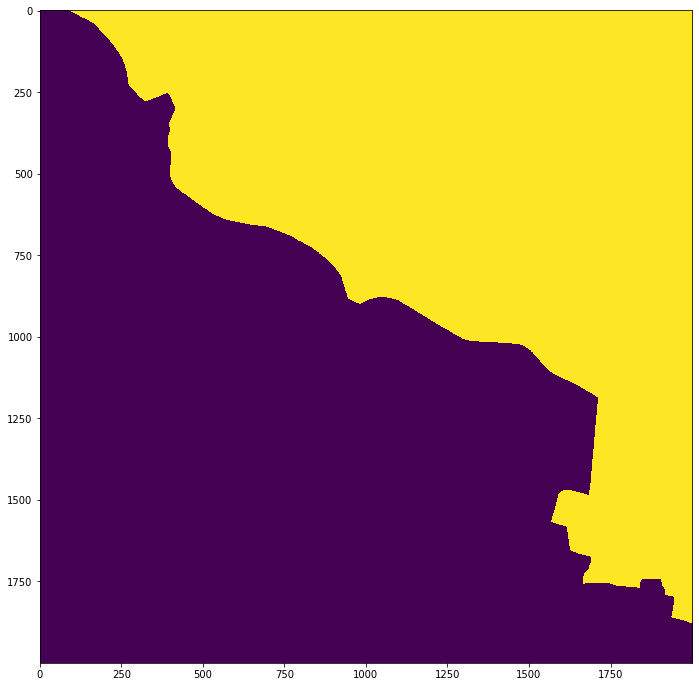

In [42]:
with rasterio.open('./target_tifs/masked_dist.tif') as dist_mask:
    mandya_dist_mask = dist_mask.read(4)

fig = plt.figure(figsize=(18, 12))
plot.show(mandya_dist_mask[6000:8000, 1500:3500])

### Data Pre-processing

In [43]:
final_features = np.array(final_feature_array) # Each training example (so reshape into (12032*10131, 14))
final_features[:,0,0]

array([ 0.0914    ,  0.0801    ,  0.0556    ,  0.0538    ,  0.0523    ,
        0.0543    ,  0.0439    ,  0.0491    ,  0.0238    ,  0.0207    ,
       -0.11758794,  0.40050378, -0.29689808])

In [44]:
final_features.shape

(13, 2000, 2000)

In [45]:
for i in range(len(final_features)):
    print(feature_list[i], "=", final_features[i].min(), final_features[i].max())

S2_Mandya_B2 = 0.0743 0.6991
S2_Mandya_B3 = 0.0591 0.7508
S2_Mandya_B4 = 0.0366 0.8609
S2_Mandya_B05 = 0.0377 0.6798
S2_Mandya_B06 = 0.0305 0.672
S2_Mandya_B07 = 0.0312 0.7329
S2_Mandya_B8 = 0.0246 0.8806
S2_Mandya_B08A = 0.0248 0.772
S2_Mandya_B11 = 0.0087 1.246
S2_Mandya_B12 = 0.005 1.196
ndvi_8_4 = -0.5315789473684212 0.8222878851836217
mndwi_4_11 = -0.733407232922267 0.8226086956521739
ndbi_11_8 = -0.6794133053954952 0.5165311653116531


In [46]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

In [47]:
normalized_features = []

In [48]:
for i in range(len(final_feature_array)):
    print(i)
    normalized_features.append(normalize(final_feature_array[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12


In [49]:
normalized_features = np.array(normalized_features)
normalized_features.shape

(13, 2000, 2000)

In [50]:
shp = normalized_features.shape
pd.DataFrame(normalized_features.reshape((shp[0], shp[1]*shp[2])))

,0,1,2,3,4,5,6,7,8,9,...,3999990,3999991,3999992,3999993,3999994,3999995,3999996,3999997,3999998,3999999
0,0.027369,0.028489,0.027049,0.025608,0.026088,0.026088,0.025768,0.026088,0.028009,0.028489,...,0.157650,0.067222,0.072023,0.092190,0.083547,0.056178,0.070583,0.086908,0.062420,0.056018
1,0.030360,0.030215,0.031083,0.031083,0.030794,0.030794,0.032529,0.032384,0.032095,0.032095,...,0.168859,0.085008,0.097441,0.105682,0.086887,0.070262,0.091658,0.086454,0.085153,0.081394
2,0.023050,0.020624,0.019410,0.019774,0.020381,0.020745,0.020138,0.019653,0.019046,0.019289,...,0.211573,0.075337,0.106029,0.135388,0.106515,0.084435,0.103239,0.122286,0.117433,0.111610
3,0.025074,0.024295,0.024295,0.022738,0.022738,0.022271,0.022271,0.022738,0.022738,0.023361,...,0.269428,0.269428,0.186420,0.186420,0.178165,0.178165,0.186887,0.186887,0.183305,0.183305
4,0.033983,0.032424,0.032424,0.031800,0.031800,0.031645,0.031645,0.030709,0.030709,0.027747,...,0.377085,0.377085,0.272798,0.272798,0.245830,0.245830,0.300390,0.300390,0.297896,0.297896
5,0.032920,0.030212,0.030212,0.028930,0.028930,0.029357,0.029357,0.029500,0.029500,0.030070,...,0.389625,0.389625,0.278752,0.278752,0.266496,0.266496,0.324640,0.324640,0.320365,0.320365
6,0.022547,0.022547,0.021379,0.021145,0.020794,0.019509,0.019860,0.020444,0.021028,0.021028,...,0.336682,0.258762,0.244977,0.219276,0.184229,0.201285,0.239019,0.267757,0.267757,0.249299
7,0.032521,0.031585,0.031585,0.029577,0.029577,0.029443,0.029443,0.029309,0.029309,0.029176,...,0.390391,0.390391,0.292291,0.292291,0.282789,0.282789,0.331906,0.331906,0.334449,0.334449
8,0.012204,0.011557,0.011557,0.012285,0.012285,0.011477,0.011477,0.011719,0.011719,0.012204,...,0.246747,0.246747,0.197123,0.197123,0.187505,0.187505,0.192920,0.192920,0.197042,0.197042
9,0.013182,0.012343,0.012343,0.012594,0.012594,0.012510,0.012510,0.012175,0.012175,0.012678,...,0.284803,0.284803,0.166751,0.166751,0.177330,0.177330,0.171704,0.171704,0.160789,0.160789


In [51]:
normalized_features = normalized_features.reshape((shp[0], shp[1]*shp[2]))

In [52]:
normalized_features.shape

(13, 4000000)

In [53]:
# pd.DataFrame(normalized_features.T).to_csv("./Understanding the Data/reshaped_norm_features.csv")

In [54]:
normalized_features = normalized_features.T

In [55]:
# Train data is done
# Target must be obtained (0/1)
mandya_dist_mask = mandya_dist_mask[6000:8000, 1500:3500]
mandya_water_mask = mandya_water_mask[6000:8000, 1500:3500]

In [56]:
mandya_dist_mask

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [57]:
normalized_features.shape

(4000000, 13)

In [58]:
# 1. Map pixel numbers to x,y coordinates of image
# 2. Choose only those pixels that are inside the mandya region
# 3. Choose target as 1 if pixel number in both masks is non-zero
# mandya_dist_mask, mandya_water_mask
pixel_positions = []
in_mandya_features = []
target_values = []
dim = mandya_dist_mask.shape
for i in range(dim[0]):
    for j in range(dim[1]):
        if(mandya_dist_mask[i,j]!=0):
            in_mandya_features.append(normalized_features[i*dim[0]+j])
            pixel_positions.append((i,j))
            if(mandya_water_mask[i,j]!=0):
                target_values.append(1)
            else:
                target_values.append(0)
            if(i%1000==0 or j%1000==0):
                print((i*dim[0]+j, i, j))

(88, 0, 88)
(89, 0, 89)
(90, 0, 90)
(91, 0, 91)
(92, 0, 92)
(93, 0, 93)
(94, 0, 94)
(95, 0, 95)
(96, 0, 96)
(97, 0, 97)
(98, 0, 98)
(99, 0, 99)
(100, 0, 100)
(101, 0, 101)
(102, 0, 102)
(103, 0, 103)
(104, 0, 104)
(105, 0, 105)
(106, 0, 106)
(107, 0, 107)
(108, 0, 108)
(109, 0, 109)
(110, 0, 110)
(111, 0, 111)
(112, 0, 112)
(113, 0, 113)
(114, 0, 114)
(115, 0, 115)
(116, 0, 116)
(117, 0, 117)
(118, 0, 118)
(119, 0, 119)
(120, 0, 120)
(121, 0, 121)
(122, 0, 122)
(123, 0, 123)
(124, 0, 124)
(125, 0, 125)
(126, 0, 126)
(127, 0, 127)
(128, 0, 128)
(129, 0, 129)
(130, 0, 130)
(131, 0, 131)
(132, 0, 132)
(133, 0, 133)
(134, 0, 134)
(135, 0, 135)
(136, 0, 136)
(137, 0, 137)
(138, 0, 138)
(139, 0, 139)
(140, 0, 140)
(141, 0, 141)
(142, 0, 142)
(143, 0, 143)
(144, 0, 144)
(145, 0, 145)
(146, 0, 146)
(147, 0, 147)
(148, 0, 148)
(149, 0, 149)
(150, 0, 150)
(151, 0, 151)
(152, 0, 152)
(153, 0, 153)
(154, 0, 154)
(155, 0, 155)
(156, 0, 156)
(157, 0, 157)
(158, 0, 158)
(159, 0, 159)
(160, 0, 160)
(1

(11000, 5, 1000)
(13000, 6, 1000)
(15000, 7, 1000)
(17000, 8, 1000)
(19000, 9, 1000)
(21000, 10, 1000)
(23000, 11, 1000)
(25000, 12, 1000)
(27000, 13, 1000)
(29000, 14, 1000)
(31000, 15, 1000)
(33000, 16, 1000)
(35000, 17, 1000)
(37000, 18, 1000)
(39000, 19, 1000)
(41000, 20, 1000)
(43000, 21, 1000)
(45000, 22, 1000)
(47000, 23, 1000)
(49000, 24, 1000)
(51000, 25, 1000)
(53000, 26, 1000)
(55000, 27, 1000)
(57000, 28, 1000)
(59000, 29, 1000)
(61000, 30, 1000)
(63000, 31, 1000)
(65000, 32, 1000)
(67000, 33, 1000)
(69000, 34, 1000)
(71000, 35, 1000)
(73000, 36, 1000)
(75000, 37, 1000)
(77000, 38, 1000)
(79000, 39, 1000)
(81000, 40, 1000)
(83000, 41, 1000)
(85000, 42, 1000)
(87000, 43, 1000)
(89000, 44, 1000)
(91000, 45, 1000)
(93000, 46, 1000)
(95000, 47, 1000)
(97000, 48, 1000)
(99000, 49, 1000)
(101000, 50, 1000)
(103000, 51, 1000)
(105000, 52, 1000)
(107000, 53, 1000)
(109000, 54, 1000)
(111000, 55, 1000)
(113000, 56, 1000)
(115000, 57, 1000)
(117000, 58, 1000)
(119000, 59, 1000)
(1210

(857000, 428, 1000)
(859000, 429, 1000)
(861000, 430, 1000)
(863000, 431, 1000)
(865000, 432, 1000)
(867000, 433, 1000)
(869000, 434, 1000)
(871000, 435, 1000)
(873000, 436, 1000)
(875000, 437, 1000)
(877000, 438, 1000)
(879000, 439, 1000)
(881000, 440, 1000)
(883000, 441, 1000)
(885000, 442, 1000)
(887000, 443, 1000)
(889000, 444, 1000)
(891000, 445, 1000)
(893000, 446, 1000)
(895000, 447, 1000)
(897000, 448, 1000)
(899000, 449, 1000)
(901000, 450, 1000)
(903000, 451, 1000)
(905000, 452, 1000)
(907000, 453, 1000)
(909000, 454, 1000)
(911000, 455, 1000)
(913000, 456, 1000)
(915000, 457, 1000)
(917000, 458, 1000)
(919000, 459, 1000)
(921000, 460, 1000)
(923000, 461, 1000)
(925000, 462, 1000)
(927000, 463, 1000)
(929000, 464, 1000)
(931000, 465, 1000)
(933000, 466, 1000)
(935000, 467, 1000)
(937000, 468, 1000)
(939000, 469, 1000)
(941000, 470, 1000)
(943000, 471, 1000)
(945000, 472, 1000)
(947000, 473, 1000)
(949000, 474, 1000)
(951000, 475, 1000)
(953000, 476, 1000)
(955000, 477, 1000)


(1689000, 844, 1000)
(1691000, 845, 1000)
(1693000, 846, 1000)
(1695000, 847, 1000)
(1697000, 848, 1000)
(1699000, 849, 1000)
(1701000, 850, 1000)
(1703000, 851, 1000)
(1705000, 852, 1000)
(1707000, 853, 1000)
(1709000, 854, 1000)
(1711000, 855, 1000)
(1713000, 856, 1000)
(1715000, 857, 1000)
(1717000, 858, 1000)
(1719000, 859, 1000)
(1721000, 860, 1000)
(1723000, 861, 1000)
(1725000, 862, 1000)
(1727000, 863, 1000)
(1729000, 864, 1000)
(1731000, 865, 1000)
(1733000, 866, 1000)
(1735000, 867, 1000)
(1737000, 868, 1000)
(1739000, 869, 1000)
(1741000, 870, 1000)
(1743000, 871, 1000)
(1745000, 872, 1000)
(1747000, 873, 1000)
(1749000, 874, 1000)
(1751000, 875, 1000)
(1753000, 876, 1000)
(1755000, 877, 1000)
(1757000, 878, 1000)
(1759000, 879, 1000)
(1761000, 880, 1000)
(1763000, 881, 1000)
(1765000, 882, 1000)
(1767000, 883, 1000)
(1769000, 884, 1000)
(1771000, 885, 1000)
(1773000, 886, 1000)
(1775000, 887, 1000)
(1777000, 888, 1000)
(1779000, 889, 1000)
(2001283, 1000, 1283)
(2001284, 10

In [59]:
len(pixel_positions)

1725828

In [60]:
print((750, 1000) in pixel_positions) # Check pixel coordinates in ndvi / mndwi image
index = pixel_positions.index((750, 1000))
print(index)
print(in_mandya_features[index])
print(target_values[index])

True
1199699
[0.22695262 0.26152956 0.21266529 0.23002648 0.20296181 0.19324498
 0.14906542 0.17545503 0.10312778 0.08698573 0.27152819 0.61087025
 0.52201475]
1


In [61]:
# arr = range(0, len(in_mandya_features), 500000)
# for i in arr[10:]:
#     if(i==arr[-1]):
#         X_train = pd.DataFrame(in_mandya_features[i:])
#         X_train["target"] = target_values[i:]
#         X_train.to_csv("./Train Data/Train_data_"+str(i)+"_"+str(len(in_mandya_features))+".csv")
#     else:
#         X_train = pd.DataFrame(in_mandya_features[i:i+500000])
#         X_train["target"] = target_values[i:i+500000]
#         X_train.to_csv("./Train Data/Train_data_"+str(i)+"_"+str(i+500000)+".csv")

In [62]:
X_train = pd.DataFrame(in_mandya_features)
X_train["target"] = target_values
X_train["pixel_positions"] = pixel_positions

In [63]:
X_train
#X_train.to_csv("./Small_Train_data.csv")

,0,1,2,3,4,5,6,7,8,9,10,11,12,target,pixel_positions
0,0.031050,0.039179,0.027175,0.033172,0.034918,0.035770,0.026285,0.039213,0.017457,0.018640,0.309795,0.677882,0.386606,0,"(0, 88)"
1,0.029930,0.039179,0.025234,0.029279,0.037101,0.037338,0.025467,0.034930,0.016972,0.018220,0.314363,0.675721,0.384604,0,"(0, 89)"
2,0.031370,0.039468,0.026447,0.029279,0.037101,0.037338,0.027570,0.034930,0.016972,0.018220,0.321962,0.680696,0.369523,0,"(0, 90)"
3,0.032810,0.038022,0.025234,0.030681,0.038036,0.035770,0.027103,0.034529,0.016892,0.018304,0.325234,0.676695,0.371481,0,"(0, 91)"
4,0.031530,0.038456,0.025840,0.030681,0.038036,0.035770,0.026051,0.034529,0.016892,0.018304,0.315110,0.679193,0.379005,0,"(0, 92)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725823,0.066421,0.075322,0.091593,0.149354,0.315511,0.341884,0.272079,0.367639,0.151782,0.099412,0.683211,0.295572,0.455750,0,"(1878, 1996)"
1725824,0.072023,0.077490,0.096445,0.145772,0.267654,0.321220,0.200584,0.311831,0.151055,0.100672,0.582259,0.307422,0.566604,0,"(1878, 1997)"
1725825,0.057778,0.068961,0.079704,0.145772,0.267654,0.321220,0.254907,0.311831,0.151055,0.100672,0.693353,0.270058,0.478073,0,"(1878, 1998)"
1725826,0.035531,0.047709,0.067209,0.161657,0.312237,0.332763,0.268925,0.356531,0.144912,0.093955,0.739374,0.250994,0.441956,0,"(1878, 1999)"


In [64]:
x_small = X_train[X_train[11] >= 0.5]
x_small[x_small["target"]==1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,target,pixel_positions
60,0.035851,0.044528,0.031421,0.034418,0.039595,0.038620,0.028505,0.037072,0.015356,0.016709,0.303208,0.719283,0.335892,1,"(0, 148)"
61,0.034091,0.043227,0.031785,0.034418,0.039595,0.038620,0.028621,0.037072,0.015356,0.016709,0.302207,0.720592,0.335105,1,"(0, 149)"
62,0.033291,0.044528,0.030329,0.034263,0.040530,0.038050,0.028505,0.037206,0.016488,0.016793,0.308490,0.701620,0.355043,1,"(0, 150)"
63,0.033611,0.044817,0.030086,0.034263,0.040530,0.038050,0.028388,0.037206,0.016488,0.016793,0.308931,0.700708,0.355842,1,"(0, 151)"
64,0.034411,0.045829,0.029237,0.032549,0.038504,0.038335,0.027570,0.036403,0.015275,0.016373,0.307855,0.712246,0.340857,1,"(0, 152)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595768,0.052177,0.067370,0.071819,0.097181,0.110366,0.146929,0.083411,0.127677,0.063606,0.038959,0.393408,0.500804,0.528888,1,"(1424, 1709)"
1595770,0.084507,0.101489,0.077156,0.114780,0.102104,0.084082,0.062967,0.078025,0.045421,0.036104,0.302944,0.608745,0.488797,1,"(1424, 1711)"
1595771,0.077625,0.119127,0.092321,0.114780,0.102104,0.084082,0.102687,0.078025,0.045421,0.036104,0.391982,0.644307,0.343739,1,"(1424, 1712)"
1596082,0.058259,0.072286,0.053015,0.062140,0.116602,0.117714,0.055958,0.117907,0.051321,0.031654,0.354933,0.505472,0.566364,1,"(1425, 1711)"


In [65]:
X_train.to_csv("./final_data.csv")